In [ ]:
import numpy as np
from numpy import asarray
import pandas as pd
from matplotlib import image
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from sklearn.model_selection import train_test_split
from skimage import io, transform

import PIL
from PIL import Image
import cv2
import random
import time
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!unzip gdrive/MyDrive/Artwork.zip

In [ ]:
artists = pd.read_csv('gdrive/MyDrive/artists.csv')
artists.drop(artists[artists['paintings']<200].index, inplace=True)
artists.sort_values(by="name", inplace = True)
artists.drop(columns=["years", "nationality", "bio", "wikipedia"], inplace=True)
artists["id"] = range(0,11)
artists.reset_index(drop=True, inplace=True)
artists.replace('\s+', '_',regex=True,inplace=True)
artists.columns=["ID", "Name", "Genre", "Paintings"]
artists["Name"].replace("Albrecht_Dürer", "Albrecht_Durer", inplace=True)
artists

,ID,Name,Genre,Paintings
0,0,Albrecht_Durer,Northern_Renaissance,328
1,1,Alfred_Sisley,Impressionism,259
2,2,Edgar_Degas,Impressionism,702
3,3,Francisco_Goya,Romanticism,291
4,4,Marc_Chagall,Primitivism,239
5,5,Pablo_Picasso,Cubism,439
6,6,Paul_Gauguin,"Symbolism,Post-Impressionism",311
7,7,Pierre-Auguste_Renoir,Impressionism,336
8,8,Rembrandt,Baroque,262
9,9,Titian,"High_Renaissance,Mannerism",255


In [ ]:
file = 'Artwork'
artwork = pd.DataFrame(columns=["Artist", "Path"])
for file_path in os.listdir(file):
            path = os.path.join(file, file_path)
            if os.path.isdir(path):
                for image_path in os.listdir(path):
                    input_path = os.path.join(path, image_path)
                    name = artists[artists.Name == os.path.basename(path)].ID
                    name.reset_index(drop=True, inplace=True)
                    artwork = artwork.append(pd.Series({"Artist": name[0], 
                                                        "Path": input_path}), 
                                             ignore_index=True)


In [ ]:
imgs = []
for i in range (4299):
    im = Image.open(artwork.iloc[i].Path)
    im = asarray(im)
    if (len(im.shape)!=3 or im.shape[2]!=3):
        imgs.append(i)
artwork.drop(imgs, inplace=True)
artwork.reset_index(drop=True, inplace=True)

In [ ]:
artwork

,Artist,Path
0,4,Artwork/Marc_Chagall/Marc_Chagall_97.jpg
1,4,Artwork/Marc_Chagall/Marc_Chagall_128.jpg
2,4,Artwork/Marc_Chagall/Marc_Chagall_160.jpg
3,4,Artwork/Marc_Chagall/Marc_Chagall_174.jpg
4,4,Artwork/Marc_Chagall/Marc_Chagall_161.jpg
...,...,...
4227,3,Artwork/Francisco_Goya/Francisco_Goya_282.jpg
4228,3,Artwork/Francisco_Goya/Francisco_Goya_290.jpg
4229,3,Artwork/Francisco_Goya/Francisco_Goya_19.jpg
4230,3,Artwork/Francisco_Goya/Francisco_Goya_36.jpg


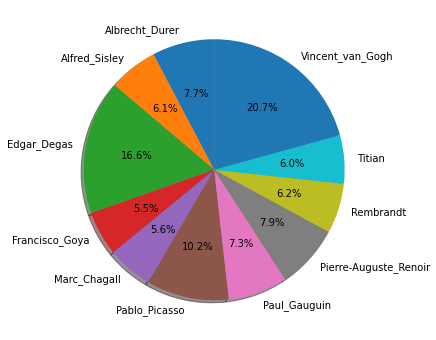

In [ ]:
x = artists.Name.unique()
plt.figure(figsize = (6,6))
plt.pie(artwork.groupby('Artist').size(), labels = x, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

In [ ]:
class Artwork(Dataset):
    def __init__(self, df, transforms=None):
        
        self.transforms = transforms
        self.df = df
                    
    def __len__(self):
        return len(self.df)
    
    def get_sample(self, idx):
        info = self.df.iloc[idx]
        im = Image.open(info["Path"])
        im = asarray(im)
        return (info["Artist"], im)
    
    def __getitem__(self, idx):
        artist, img = self.get_sample(idx)
        if self.transforms:
            img = self.transforms(img)
        means = img.mean([1,2])
        std = img.std([1,2])
        x = (artist, transforms.Normalize(means, std)(img))
        return x        

In [ ]:
composed = transforms.Compose([transforms.ToTensor(), transforms.Resize(256), 
                               transforms.RandomCrop(256), 
                               transforms.RandomHorizontalFlip(p=0.5),
                               transforms.RandomVerticalFlip(p=0.5)])

paintings = Artwork(artwork, transforms=composed)
paintings.df.head()

,Artist,Path
0,4,Artwork/Marc_Chagall/Marc_Chagall_97.jpg
1,4,Artwork/Marc_Chagall/Marc_Chagall_128.jpg
2,4,Artwork/Marc_Chagall/Marc_Chagall_160.jpg
3,4,Artwork/Marc_Chagall/Marc_Chagall_174.jpg
4,4,Artwork/Marc_Chagall/Marc_Chagall_161.jpg


In [ ]:
img = paintings.__getitem__(random.randint(0, 4298))
print(img[0], img[1].shape)

torch.Size([3, 694, 1061])
torch.Size([3, 256, 391])
torch.Size([3, 256, 256])


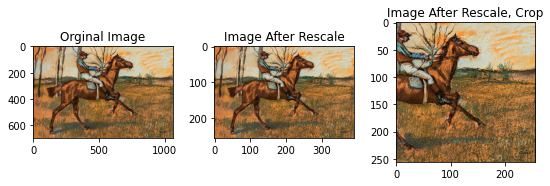

In [ ]:
img = paintings.get_sample(random.randint(0, 4298))
img = transforms.ToTensor()(img[1])
img_rscl = transforms.Resize(256)(img)
img_crop = transforms.RandomCrop(256)(img_rscl)

fig = plt.figure(figsize=(9,9))
plt.subplots_adjust(wspace = 0.3)
                    
ax = plt.subplot(1, 3, 1)
ax.set_title("Orginal Image")
plt.imshow(img.permute(1, 2, 0))
print(img.shape)

ax = plt.subplot(1, 3, 2)
ax.set_title("Image After Rescale")
plt.imshow(img_rscl.permute(1, 2, 0))
print(img_rscl.shape)

ax = plt.subplot(1, 3, 3)
ax.set_title("Image After Rescale, Crop")
plt.imshow(img_crop.permute(1, 2, 0))
print(img_crop.shape)
    
plt.show()

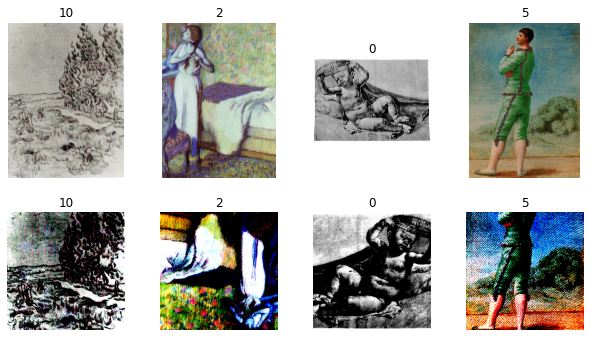

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(left = 0.1, wspace = 0.3, hspace=0.1)

for i in range(4):
    ax = plt.subplot(2, 4, i + 1)
    idx = random.randint(0, 4298)
    sample = paintings.get_sample(idx)
    ax.set_title(sample[0])
    ax.axis('off')
    plt.imshow(sample[1])
    
    ax = plt.subplot(2, 4, i + 5)
    transformed = paintings.__getitem__(idx)
    ax.set_title(transformed[0])
    ax.axis('off')
    img = np.clip(transformed[1], 0, 1)
    plt.imshow(img.permute(1, 2, 0))
    
plt.show()

In [ ]:
train, test = train_test_split(artwork, test_size=0.2, stratify=artwork.Artist)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [ ]:
train

,Artist,Path
0,6,Artwork/Paul_Gauguin/Paul_Gauguin_263.jpg
1,3,Artwork/Francisco_Goya/Francisco_Goya_203.jpg
2,10,Artwork/Vincent_van_Gogh/Vincent_van_Gogh_512.jpg
3,2,Artwork/Edgar_Degas/Edgar_Degas_82.jpg
4,10,Artwork/Vincent_van_Gogh/Vincent_van_Gogh_781.jpg
...,...,...
3380,6,Artwork/Paul_Gauguin/Paul_Gauguin_226.jpg
3381,10,Artwork/Vincent_van_Gogh/Vincent_van_Gogh_776.jpg
3382,2,Artwork/Edgar_Degas/Edgar_Degas_688.jpg
3383,2,Artwork/Edgar_Degas/Edgar_Degas_21.jpg


In [ ]:
test

,Artist,Path
0,1,Artwork/Alfred_Sisley/Alfred_Sisley_150.jpg
1,7,Artwork/Pierre-Auguste_Renoir/Pierre-Auguste_R...
2,7,Artwork/Pierre-Auguste_Renoir/Pierre-Auguste_R...
3,7,Artwork/Pierre-Auguste_Renoir/Pierre-Auguste_R...
4,10,Artwork/Vincent_van_Gogh/Vincent_van_Gogh_371.jpg
...,...,...
842,3,Artwork/Francisco_Goya/Francisco_Goya_98.jpg
843,2,Artwork/Edgar_Degas/Edgar_Degas_354.jpg
844,0,Artwork/Albrecht_Durer/Albrecht_Dürer_104.jpg
845,10,Artwork/Vincent_van_Gogh/Vincent_van_Gogh_506.jpg


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
train_dataset = Artwork(train, transforms=composed)
val_dataset = Artwork(test, transforms=composed)

train_loader = DataLoader(train_dataset, batch_size=50)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)

dataloaders = {'train':train_loader, 'val':val_loader}
dataset_sizes = {'train': len(train), 'val':len(test)}

data_weights = []
for i in range(11):
  w = float(877/artists.iloc[i].Paintings)
  data_weights.append(w)
data_w = torch.FloatTensor(data_weights)
data_w = data_w.to(device)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for labels, inputs in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 11)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0003)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [ ]:
model = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                    num_epochs=50)

Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.9547 Acc: 0.6839
val Loss: 0.8590 Acc: 0.7249

Epoch 1/49
----------
train Loss: 0.4614 Acc: 0.8446
val Loss: 0.8264 Acc: 0.7462

Epoch 2/49
----------
train Loss: 0.3193 Acc: 0.8990
val Loss: 0.6737 Acc: 0.7851

Epoch 3/49
----------
train Loss: 0.2348 Acc: 0.9241
val Loss: 0.8154 Acc: 0.7568

Epoch 4/49
----------
train Loss: 0.2118 Acc: 0.9261
val Loss: 1.1064 Acc: 0.6789

Epoch 5/49
----------
train Loss: 0.1486 Acc: 0.9551
val Loss: 0.7471 Acc: 0.7875

Epoch 6/49
----------
train Loss: 0.1238 Acc: 0.9601
val Loss: 0.8151 Acc: 0.7745

Epoch 7/49
----------
train Loss: 0.0905 Acc: 0.9681
val Loss: 0.6478 Acc: 0.8264

Epoch 8/49
----------
train Loss: 0.0960 Acc: 0.9710
val Loss: 0.7467 Acc: 0.8099

Epoch 9/49
----------
train Loss: 0.1153 Acc: 0.9625
val Loss: 0.9193 Acc: 0.7556

Epoch 10/49
----------
train Loss: 0.0794 Acc: 0.9737
val Loss: 0.7075 Acc: 0.8099

Epoch 11/49
----------
train Loss: 0.0584 Acc: 0.9849
val Loss: 0.6366 Acc: 0.8347

Epoch 12/49
----------
t